In [4]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.figure(figsize=(12, 6), dpi=100)
plt.style.use('bmh')

<Figure size 1200x600 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
# Установка библиотек, если они ещё не установлены
# !pip install numpy scikit-learn xgboost

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [6]:
df = pd.read_csv('labeled.csv')
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


# Visualization

C:\Users\Нур\AppData\Local\Temp\ipykernel_13700\2581322192.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(toxic_counts, palette='viridis')


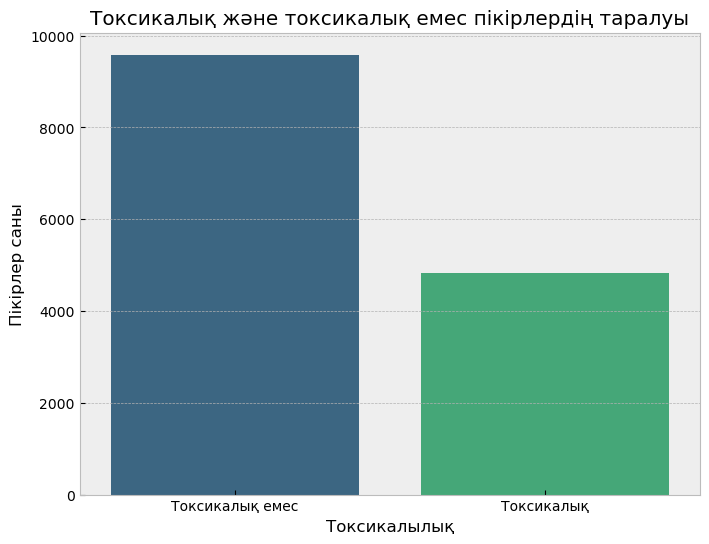

In [15]:
# 1. Распределение токсичных и нетоксичных комментариев
toxic_counts = df['toxic'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(toxic_counts, palette='viridis')
plt.title('Токсикалық және токсикалық емес пікірлердің таралуы')
plt.xlabel('Токсикалылық')
plt.ylabel('Пікірлер саны')
plt.xticks(range(len(toxic_counts.index)), ['Токсикалық емес', 'Токсикалық'])
plt.show()

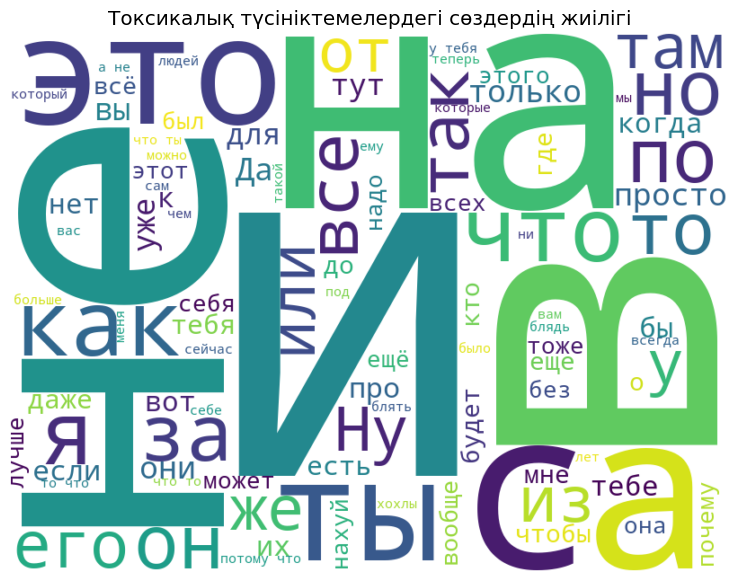

In [8]:
# 3. Частота слов в токсичных комментариях
# Собираем все токсичные комментарии в один текстовый блок
toxic_comments_text = ' '.join(df[df['toxic'] == 1]['comment'].values)

# Создаем облако слов
wordcloud = WordCloud(stopwords=ENGLISH_STOP_WORDS, background_color='white', width=800, height=600, max_words=100).generate(toxic_comments_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Токсикалық түсініктемелердегі сөздердің жиілігі')
plt.show()

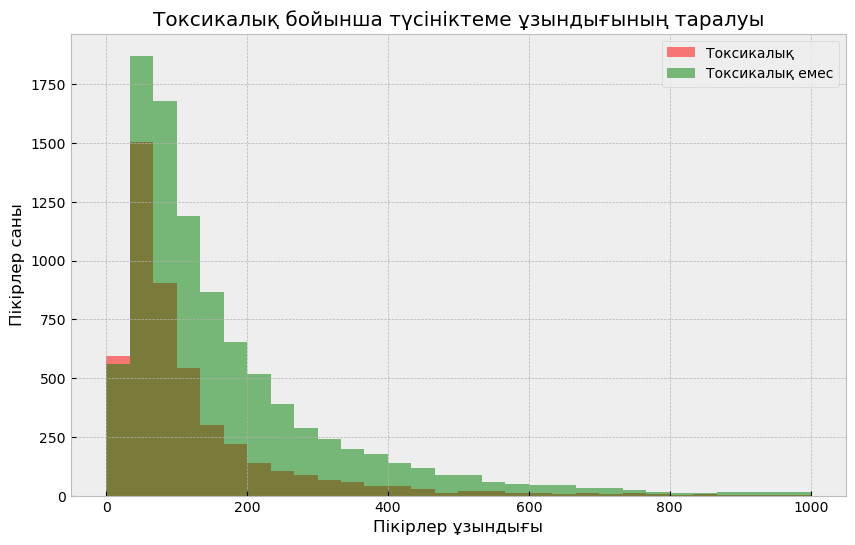

In [9]:
df['comment_length'] = df['comment'].apply(len)
# Попробуем другой подход к визуализации, используя базовые возможности matplotlib
plt.figure(figsize=(10, 6))

# Разделяем комментарии на токсичные и нетоксичные для отдельной визуализации
toxic_comments = df[df['toxic'] == 1]['comment_length']
nontoxic_comments = df[df['toxic'] == 0]['comment_length']

# Гистограмма для токсичных комментариев
plt.hist(toxic_comments, bins=30, alpha=0.5, label='Токсикалық', color='red', range=(0, 1000))

# Гистограмма для нетоксичных комментариев
plt.hist(nontoxic_comments, bins=30, alpha=0.5, label='Токсикалық емес', color='green', range=(0, 1000))

plt.title('Токсикалық бойынша түсініктеме ұзындығының таралуы')
plt.xlabel('Пікірлер ұзындығы')
plt.ylabel('Пікірлер саны')
plt.legend()
plt.show()

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(corpus, ngram_range=(2, 2), top_n=20, title=''):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=ENGLISH_STOP_WORDS)
    X = vectorizer.fit_transform(corpus)
    ngrams = vectorizer.get_feature_names_out()
    counts = X.sum(axis=0).A1
    ngram_freq = dict(zip(ngrams, counts))
    ngram_freq_sorted = sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]

    df_ngram_freq = pd.DataFrame(ngram_freq_sorted, columns=['ngram', 'count'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='ngram', data=df_ngram_freq, palette='viridis')
    plt.title(title)
    plt.xlabel('Частота')
    plt.ylabel('N-грамма')
    plt.show()

# Биграммы в токсичных комментариях
plot_top_ngrams(df[df['toxic'] == 1]['cleaned_comment'], ngram_range=(2, 2), top_n=20, title='Топ 20 биграмм в токсичных комментариях')

# Триграммы в токсичных комментариях
plot_top_ngrams(df[df['toxic'] == 1]['cleaned_comment'], ngram_range=(3, 3), top_n=20, title='Топ 20 триграмм в токсичных комментариях')


KeyError: 'cleaned_comment'

# Preprocessing

In [5]:
# Сначала загрузите nltk ресурсы (стоп-слова и стеммер), если вы еще этого не сделали
nltk.download('stopwords')

# Определение стоп-слов для русского языка
stop_words = set(stopwords.words('russian'))

# Инициализация стеммера (можно заменить на лемматизатор, если необходимо)
stemmer = SnowballStemmer('russian')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [6]:
def clean_text(text):
    # Удаление специальных символов и приведение к нижнему регистру
    text = re.sub(r'\W', ' ', str(text))
    text = text.lower()
    # Удаление одиночных символов
    text = re.sub(r'\s+[а-яА-Я]\s+', ' ', text)
    # Удаление символов в начале строки
    text = re.sub(r'\^[а-яА-Я]\s+', ' ', text) 
    # Замена множественных пробелов на один
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Удаление префикса "b"
    text = re.sub(r'^b\s+', '', text)
    # Удаление стоп-слов и стемминг
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

In [7]:
# Применение функции очистки к каждому комментарию
df['cleaned_comment'] = df['comment'].apply(clean_text)

# Проверка результатов
df[['comment', 'cleaned_comment']].head()

,comment,cleaned_comment
0,"Верблюдов-то за что? Дебилы, бл...\n",верблюд дебил бл
1,"Хохлы, это отдушина затюканого россиянина, мол...",хохл эт отдушин затюкан россиянин мол вон хохл...
2,Собаке - собачья смерть\n,собак собач смерт
3,"Страницу обнови, дебил. Это тоже не оскорблени...",страниц обнов деб эт оскорблен доказа факт деб...
4,"тебя не убедил 6-страничный пдф в том, что Скр...",убед 6 страничн пдф скрипал отрав росс анализи...


In [8]:
df['tokenized_comments'] = df['cleaned_comment'].apply(lambda x: x.split())

In [9]:
data=df[['tokenized_comments','toxic','cleaned_comment']].copy()

In [10]:
data

,tokenized_comments,toxic,cleaned_comment
0,"[верблюд, дебил, бл]",1.0,верблюд дебил бл
1,"[хохл, эт, отдушин, затюкан, россиянин, мол, в...",1.0,хохл эт отдушин затюкан россиянин мол вон хохл...
2,"[собак, собач, смерт]",1.0,собак собач смерт
3,"[страниц, обнов, деб, эт, оскорблен, доказа, ф...",1.0,страниц обнов деб эт оскорблен доказа факт деб...
4,"[убед, 6, страничн, пдф, скрипал, отрав, росс,...",1.0,убед 6 страничн пдф скрипал отрав росс анализи...
...,...,...,...
14407,"[вонюч, совков, скот, прибежа, ноет, сторонник...",1.0,вонюч совков скот прибежа ноет сторонник демок...
14408,"[ког, люб, гоблин, тупорыл, как, продажн, сук,...",1.0,ког люб гоблин тупорыл как продажн сук демшиз ...
14409,"[посмотрел, утомлен, солнц, 2, оказа, эт, хоро...",0.0,посмотрел утомлен солнц 2 оказа эт хорош фильм...
14410,"[крымотред, наруша, прав, раздел, нем, обсужде...",1.0,крымотред наруша прав раздел нем обсужден поли...


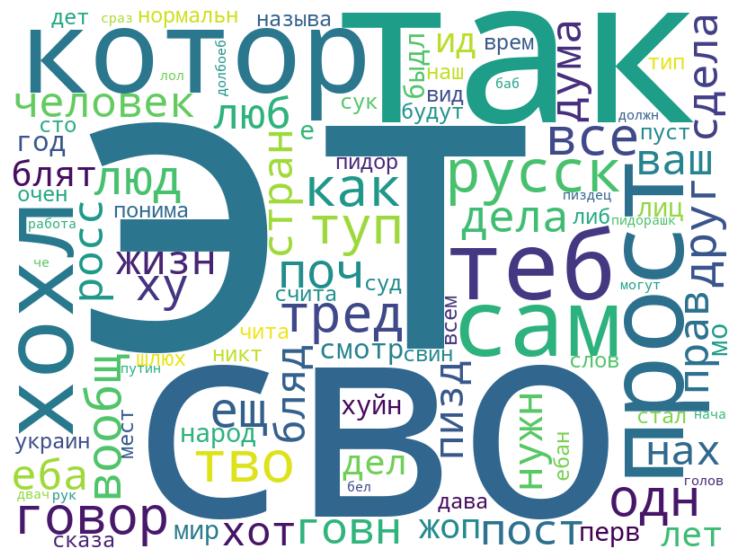

In [176]:
# 3. Частота слов в токсичных комментариях
# Собираем все токсичные комментарии в один текстовый блок
toxic_comments_text = ' '.join(df[df['toxic'] == 1]['cleaned_comment'].values)

# Создаем облако слов
wordcloud = WordCloud(stopwords=ENGLISH_STOP_WORDS, background_color='white', width=800, height=600, max_words=100).generate(toxic_comments_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
data

,tokenized_comments,toxic,cleaned_comment
0,"[верблюд, дебил, бл]",1.0,верблюд дебил бл
1,"[хохл, эт, отдушин, затюкан, россиянин, мол, в...",1.0,хохл эт отдушин затюкан россиянин мол вон хохл...
2,"[собак, собач, смерт]",1.0,собак собач смерт
3,"[страниц, обнов, деб, эт, оскорблен, доказа, ф...",1.0,страниц обнов деб эт оскорблен доказа факт деб...
4,"[убед, 6, страничн, пдф, скрипал, отрав, росс,...",1.0,убед 6 страничн пдф скрипал отрав росс анализи...
...,...,...,...
14407,"[вонюч, совков, скот, прибежа, ноет, сторонник...",1.0,вонюч совков скот прибежа ноет сторонник демок...
14408,"[ког, люб, гоблин, тупорыл, как, продажн, сук,...",1.0,ког люб гоблин тупорыл как продажн сук демшиз ...
14409,"[посмотрел, утомлен, солнц, 2, оказа, эт, хоро...",0.0,посмотрел утомлен солнц 2 оказа эт хорош фильм...
14410,"[крымотред, наруша, прав, раздел, нем, обсужде...",1.0,крымотред наруша прав раздел нем обсужден поли...


# Vectorization

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=3000)

In [13]:
data

,tokenized_comments,toxic,cleaned_comment
0,"[верблюд, дебил, бл]",1.0,верблюд дебил бл
1,"[хохл, эт, отдушин, затюкан, россиянин, мол, в...",1.0,хохл эт отдушин затюкан россиянин мол вон хохл...
2,"[собак, собач, смерт]",1.0,собак собач смерт
3,"[страниц, обнов, деб, эт, оскорблен, доказа, ф...",1.0,страниц обнов деб эт оскорблен доказа факт деб...
4,"[убед, 6, страничн, пдф, скрипал, отрав, росс,...",1.0,убед 6 страничн пдф скрипал отрав росс анализи...
...,...,...,...
14407,"[вонюч, совков, скот, прибежа, ноет, сторонник...",1.0,вонюч совков скот прибежа ноет сторонник демок...
14408,"[ког, люб, гоблин, тупорыл, как, продажн, сук,...",1.0,ког люб гоблин тупорыл как продажн сук демшиз ...
14409,"[посмотрел, утомлен, солнц, 2, оказа, эт, хоро...",0.0,посмотрел утомлен солнц 2 оказа эт хорош фильм...
14410,"[крымотред, наруша, прав, раздел, нем, обсужде...",1.0,крымотред наруша прав раздел нем обсужден поли...


In [14]:
gg=pd.DataFrame(tfidf.fit_transform(df['cleaned_comment']).toarray())

In [15]:
data=pd.concat([gg,data], axis=1)

In [16]:
data.shape

(14412, 3003)

In [17]:
# Assuming 'data' is your DataFrame
data = data.drop(['tokenized_comments', 'cleaned_comment'], axis=1)

In [18]:
data

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,toxic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Separation

In [19]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [20]:
train, validate, test = train_validate_test_split(data, train_percent=.7, validate_percent=.2, seed=700)
train.shape[0], validate.shape[0], test.shape[0]

(10088, 2882, 1442)

In [21]:
X_train = np.array(train.iloc[:,:3000])
y_train = train['toxic'].values

X_validate = np.array(validate.iloc[:,:3000])
y_validate = validate['toxic'].values

X_test = np.array(test.iloc[:,:3000])
y_test = test['toxic'].values

# Логистическая регрессия

In [201]:
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'solver': ['liblinear', 'saga']
}

# Создание GridSearchCV
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy',n_jobs=-1)
grid_lr.fit(X_train, y_train)

# Лучшие параметры и результаты
print("Лучшие параметры для логистической регрессии:", grid_lr.best_params_)
print(classification_report(y_validate, grid_lr.predict(X_validate)))

Лучшие параметры для логистической регрессии: {'C': 10, 'solver': 'liblinear'}
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.89      1938
         1.0       0.80      0.71      0.75       944

    accuracy                           0.84      2882
   macro avg       0.83      0.81      0.82      2882
weighted avg       0.84      0.84      0.84      2882



In [202]:
best_model_lr = grid_lr.best_estimator_
y_pred = best_model_lr.predict(X_test)

# Calculating metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"SVC Precision: {precision:.4f}")
print(f"SVC Recall: {recall:.4f}")
print(f"SVC F1 Score: {f1:.4f}")
print(f"SVC Accuracy: {accuracy:.4f}")

SVC Precision: 0.8353
SVC Recall: 0.8370
SVC F1 Score: 0.8335
SVC Accuracy: 0.8370


# RandomForestClassifier

In [203]:
from sklearn.ensemble import RandomForestClassifier

# Параметры для GridSearchCV
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200], # Количество деревьев
    'max_depth': [None, 10, 20, 30] # Максимальная глубина деревьев
}

# Создание GridSearchCV
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy',n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Лучшие параметры и результаты
print("Лучшие параметры для случайного леса:", grid_rf.best_params_)
print(classification_report(y_validate, grid_rf.predict(X_validate)))


Лучшие параметры для случайного леса: {'max_depth': None, 'n_estimators': 100}
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      1938
         1.0       0.76      0.70      0.73       944

    accuracy                           0.83      2882
   macro avg       0.81      0.80      0.80      2882
weighted avg       0.83      0.83      0.83      2882



In [204]:
best_model_rf = grid_rf.best_estimator_
y_pred = best_model_rf.predict(X_test)

# Calculating metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"SVC Precision: {precision:.4f}")
print(f"SVC Recall: {recall:.4f}")
print(f"SVC F1 Score: {f1:.4f}")
print(f"SVC Accuracy: {accuracy:.4f}")

SVC Precision: 0.8272
SVC Recall: 0.8294
SVC F1 Score: 0.8274
SVC Accuracy: 0.8294


# xgboost

In [28]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

# Параметры для RandomizedSearchCV
param_grid_xgb = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 3, 5],
}

# Создание RandomizedSearchCV
random_search = RandomizedSearchCV(xgb.XGBClassifier(),
                                   param_distributions=param_grid_xgb,
                                   n_iter=10,  # Количество итераций для случайного поиска
                                   scoring='accuracy',
                                   cv=3,  # Уменьшенное количество кросс-валидаций
                                   verbose=1,
                                   random_state=42,
                                   n_jobs=-1)

random_search.fit(X_train, y_train)

# Лучшие параметры и результаты
print("Лучшие параметры для XGBoost:", random_search.best_params_)
print(classification_report(y_validate, random_search.predict(X_validate)))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
best_model_xgb = grid_xgb.best_estimator_
y_pred = best_model_xgb.predict(X_test)

# Calculating metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"SVC Precision: {precision:.4f}")
print(f"SVC Recall: {recall:.4f}")
print(f"SVC F1 Score: {f1:.4f}")
print(f"SVC Accuracy: {accuracy:.4f}")

In [30]:
import xgboost as xgb

# Параметры для GridSearchCV
param_grid_xgb = {
#     'n_estimators': [100, 150, 200],
#     'learning_rate': [0.001, 0.01,  0.1],
#     'max_depth': [3, 4, 5, 6, 7, 8, 9],
#     'min_child_weight': [1, 3, 5, 7],
}
model=xgb.XGBClassifier()

# Создание GridSearchCV
# grid_xgb = GridSearchCV(, param_grid_xgb, verbose=1,cv=5, scoring='accuracy',n_jobs=-1)
model.fit(X_train, y_train)

# Лучшие параметры и результаты
# print("Лучшие параметры для XGBoost:", grid_xgb.best_params_)
print(classification_report(y_validate, model.predict(X_validate)))

              precision    recall  f1-score   support

         0.0       0.80      0.96      0.88      1938
         1.0       0.87      0.52      0.65       944

    accuracy                           0.82      2882
   macro avg       0.84      0.74      0.76      2882
weighted avg       0.83      0.82      0.80      2882



In [31]:
best_model_xgb = model
y_pred = best_model_xgb.predict(X_test)

# Calculating metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"SVC Precision: {precision:.4f}")
print(f"SVC Recall: {recall:.4f}")
print(f"SVC F1 Score: {f1:.4f}")
print(f"SVC Accuracy: {accuracy:.4f}")

SVC Precision: 0.8259
SVC Recall: 0.8121
SVC F1 Score: 0.7973
SVC Accuracy: 0.8121


# GaussianNB

In [32]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Параметры для RandomizedSearchCV
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

# Создание RandomizedSearchCV
random_search_nb = RandomizedSearchCV(GaussianNB(),
                                      param_distributions=param_grid_nb,
                                      n_iter=4,  # Точное количество итераций, так как параметров мало
                                      scoring='accuracy',
                                      cv=3,
                                      verbose=1,
                                      random_state=42,
                                      n_jobs=-1)

random_search_nb.fit(X_train, y_train)

# Лучшие параметры и результаты
print("Лучшие параметры для Naive Bayes:", random_search_nb.best_params_)
print(classification_report(y_validate, random_search_nb.predict(X_validate)))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Лучшие параметры для Naive Bayes: {'var_smoothing': 1e-06}
              precision    recall  f1-score   support

         0.0       0.90      0.68      0.78      1938
         1.0       0.56      0.84      0.67       944

    accuracy                           0.73      2882
   macro avg       0.73      0.76      0.72      2882
weighted avg       0.79      0.73      0.74      2882



In [33]:
best_model_xgb = random_search_nb.best_estimator_
y_pred = best_model_xgb.predict(X_test)

# Calculating metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"SVC Precision: {precision:.4f}")
print(f"SVC Recall: {recall:.4f}")
print(f"SVC F1 Score: {f1:.4f}")
print(f"SVC Accuracy: {accuracy:.4f}")

SVC Precision: 0.7800
SVC Recall: 0.7399
SVC F1 Score: 0.7460
SVC Accuracy: 0.7399


# SVC

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Параметры для RandomizedSearchCV
param_grid_svm = {
    'C': [0.1, 1, 10, 100],  # Регуляризационный параметр
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']  # Параметр ядра
}

# Создание RandomizedSearchCV
random_search_svm = RandomizedSearchCV(SVC(),
                                       param_distributions=param_grid_svm,
                                       n_iter=10,
                                       scoring='accuracy',
                                       cv=3,
                                       verbose=1,
                                       random_state=42,
                                       n_jobs=-1)

random_search_svm.fit(X_train, y_train)

# Лучшие параметры и результаты
print("Лучшие параметры для SVM:", random_search_svm.best_params_)
print(classification_report(y_validate, random_search_svm.predict(X_validate)))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [36]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Параметры для RandomizedSearchCV

model=SVC()
model.fit(X_train, y_train)

# Лучшие параметры и результаты
print(classification_report(y_validate, model.predict(X_validate)))

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90      1938
         1.0       0.88      0.68      0.76       944

    accuracy                           0.86      2882
   macro avg       0.87      0.82      0.83      2882
weighted avg       0.86      0.86      0.86      2882



In [37]:
best_model_xgb = model
y_pred = best_model_xgb.predict(X_test)

# Calculating metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"SVC Precision: {precision:.4f}")
print(f"SVC Recall: {recall:.4f}")
print(f"SVC F1 Score: {f1:.4f}")
print(f"SVC Accuracy: {accuracy:.4f}")

SVC Precision: 0.8563
SVC Recall: 0.8544
SVC F1 Score: 0.8495
SVC Accuracy: 0.8544


# Results

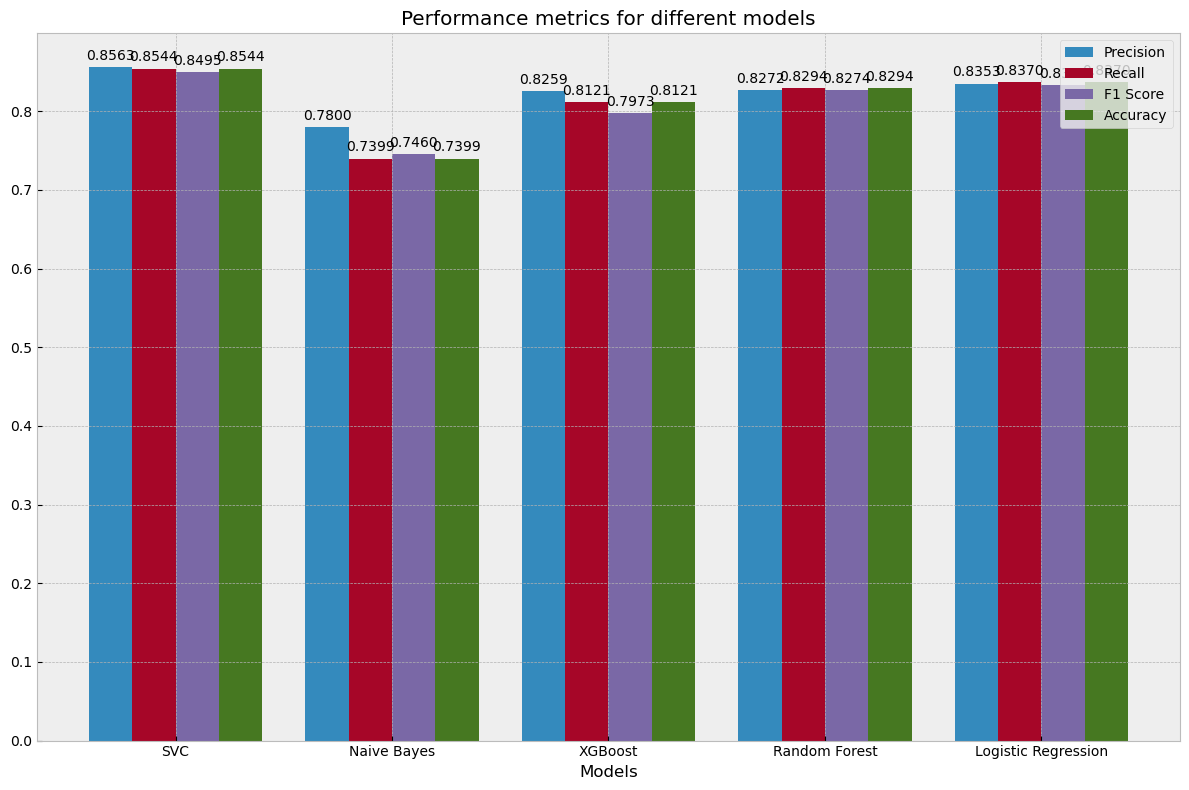

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Названия моделей
models = ['SVC', 'Naive Bayes', 'XGBoost', 'Random Forest', 'Logistic Regression']

# Значения метрик для каждой модели
precision = [0.8563, 0.7800, 0.8259, 0.8272, 0.8353]
recall = [0.8544, 0.7399, 0.8121, 0.8294, 0.8370]
f1_score = [0.8495, 0.7460, 0.7973, 0.8274, 0.8335]
accuracy = [0.8544, 0.7399, 0.8121, 0.8294, 0.8370]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width*1.5, precision, width, label='Precision')
rects2 = ax.bar(x - width/2, recall, width, label='Recall')
rects3 = ax.bar(x + width/2, f1_score, width, label='F1 Score')
rects4 = ax.bar(x + width*1.5, accuracy, width, label='Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_title('Performance metrics for different models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Attach a text label above each bar in rects, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()


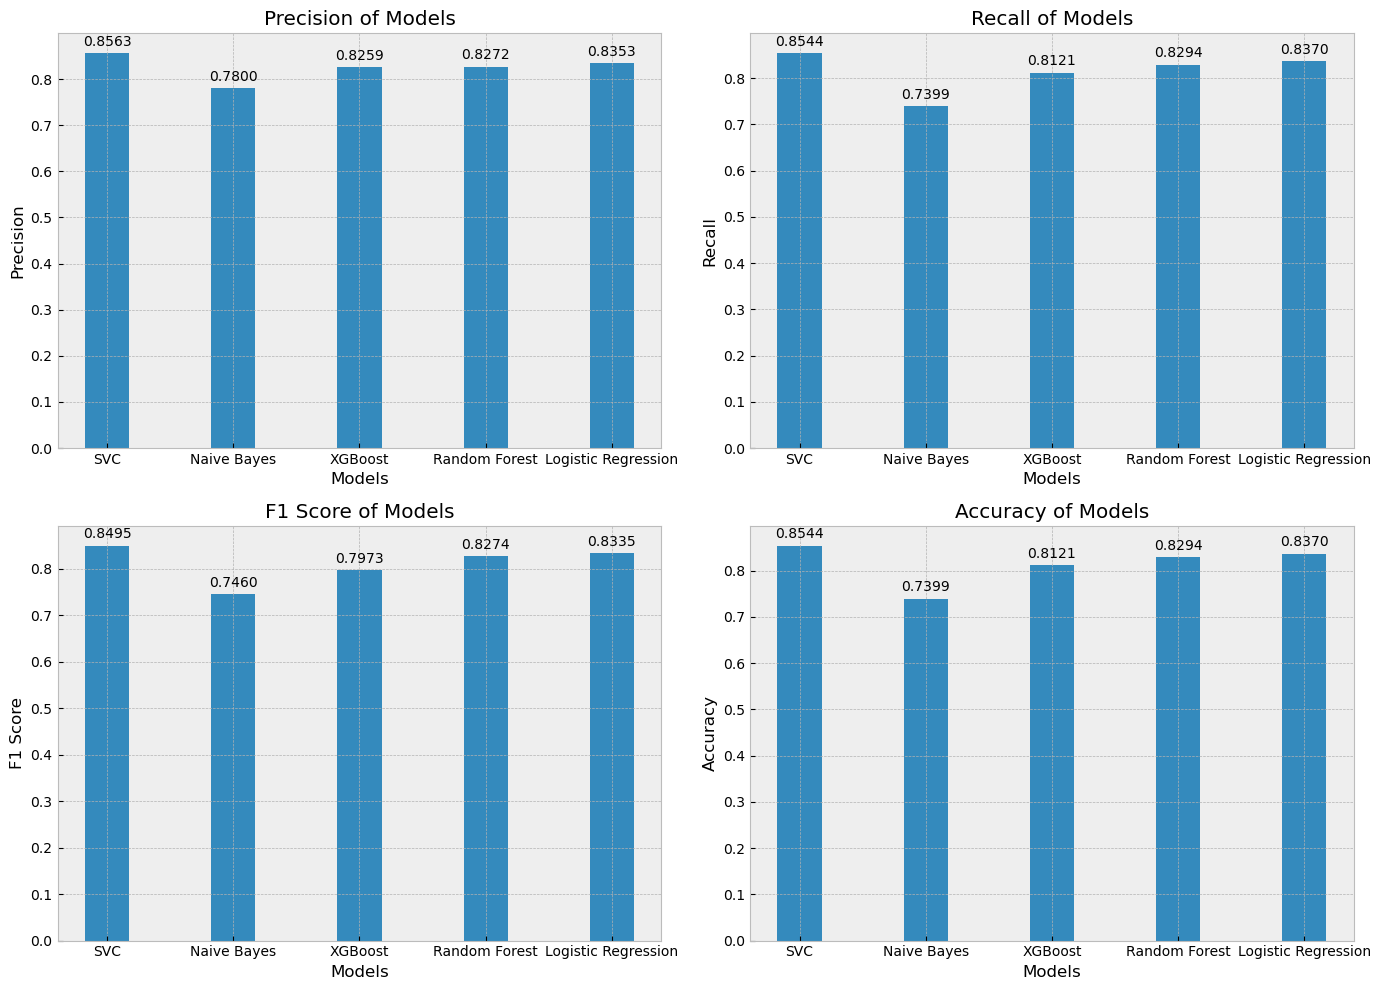

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Названия моделей
models = ['SVC', 'Naive Bayes', 'XGBoost', 'Random Forest', 'Logistic Regression']

# Значения метрик для каждой модели
precision = [0.8563, 0.7800, 0.8259, 0.8272, 0.8353]
recall = [0.8544, 0.7399, 0.8121, 0.8294, 0.8370]
f1_score = [0.8495, 0.7460, 0.7973, 0.8274, 0.8335]
accuracy = [0.8544, 0.7399, 0.8121, 0.8294, 0.8370]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

# Функция для создания графика
def create_plot(values, title, ylabel, ax):
    rects = ax.bar(x, values, width)
    ax.set_xlabel('Models')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylabel(ylabel)
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # создаем сетку для графиков

# Создание отдельных графиков
create_plot(precision, 'Precision of Models', 'Precision', axs[0, 0])
create_plot(recall, 'Recall of Models', 'Recall', axs[0, 1])
create_plot(f1_score, 'F1 Score of Models', 'F1 Score', axs[1, 0])
create_plot(accuracy, 'Accuracy of Models', 'Accuracy', axs[1, 1])

fig.tight_layout()
plt.show()


In [42]:
import pandas as pd

# Названия моделей
models = ['SVC', 'Naive Bayes', 'XGBoost', 'Random Forest', 'Logistic Regression']

# Значения метрик для каждой модели
data = {
    'Model': models,
    'Precision': [0.8563, 0.7800, 0.8259, 0.8272, 0.8353],
    'Recall': [0.8544, 0.7399, 0.8121, 0.8294, 0.8370],
    'F1 Score': [0.8495, 0.7460, 0.7973, 0.8274, 0.8335],
    'Accuracy': [0.8544, 0.7399, 0.8121, 0.8294, 0.8370]
}

# Создание датафрейма
df_performance = pd.DataFrame(data)

(df_performance)


,Model,Precision,Recall,F1 Score,Accuracy
0,SVC,0.8563,0.8544,0.8495,0.8544
1,Naive Bayes,0.7800,0.7399,0.7460,0.7399
2,XGBoost,0.8259,0.8121,0.7973,0.8121
3,Random Forest,0.8272,0.8294,0.8274,0.8294
4,Logistic Regression,0.8353,0.8370,0.8335,0.8370


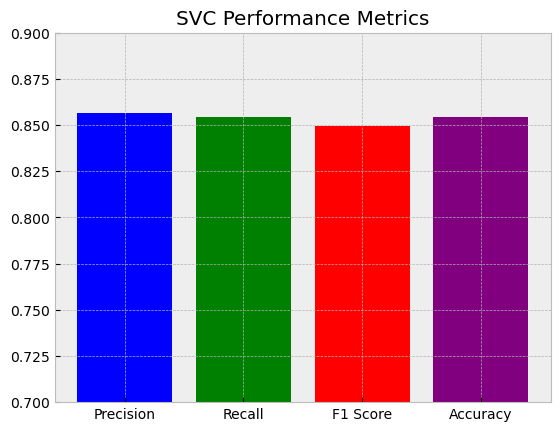

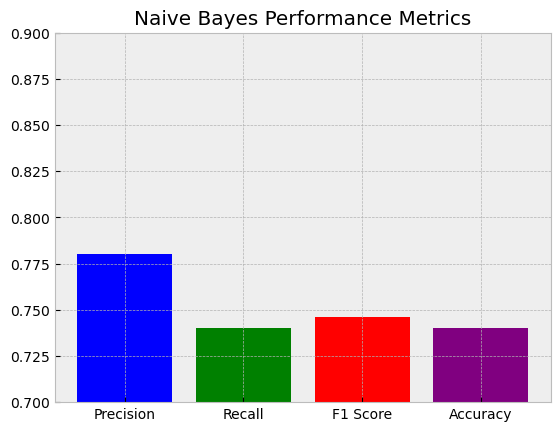

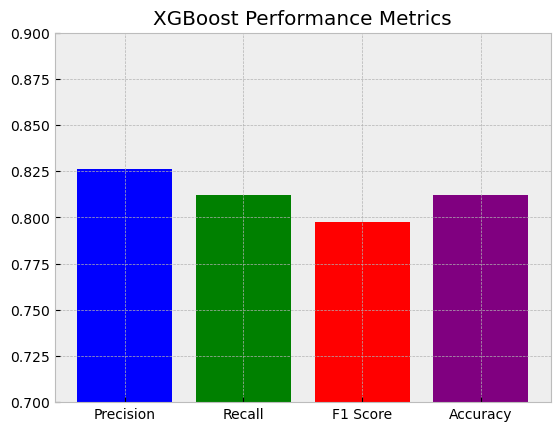

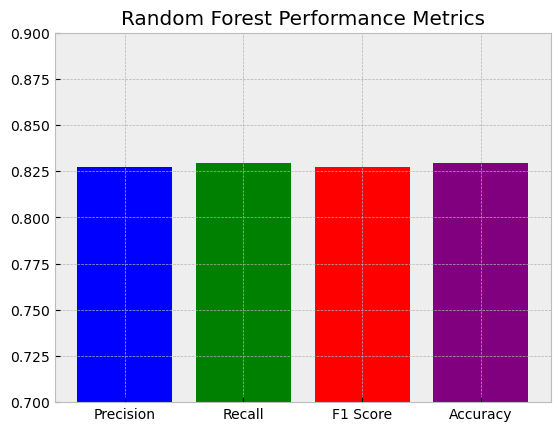

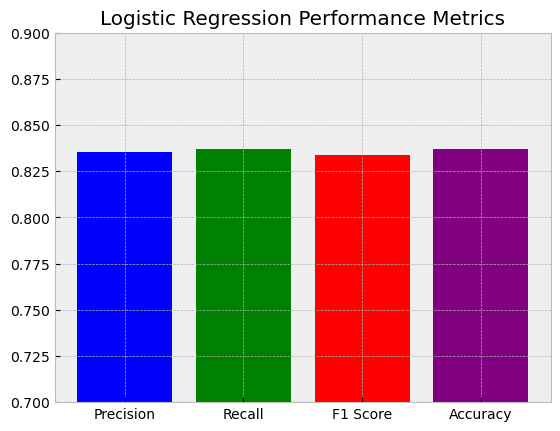

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Названия моделей и соответствующие данные
models = ['SVC', 'Naive Bayes', 'XGBoost', 'Random Forest', 'Logistic Regression']
data = {
    'SVC': [0.8563, 0.8544, 0.8495, 0.8544],
    'Naive Bayes': [0.7800, 0.7399, 0.7460, 0.7399],
    'XGBoost': [0.8259, 0.8121, 0.7973, 0.8121],
    'Random Forest': [0.8272, 0.8294, 0.8274, 0.8294],
    'Logistic Regression': [0.8353, 0.8370, 0.8335, 0.8370]
}

# Метрики
metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy']

# Создание отдельного графика для каждой модели
for model in models:
    fig, ax = plt.subplots()
    values = data[model]
    ax.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
    ax.set_title(f'{model} Performance Metrics')
    ax.set_ylim(0.7, 0.9)  # Настройка пределов оси Y для улучшения читаемости
    plt.show()


# Save Results

In [ ]:
from joblib import load

# Загрузка моделей из папки models
loaded_model_lr = load('models/best_model_lr.joblib')
loaded_model_rf = load('models/best_model_rf.joblib')
loaded_model_xgb = load('models/best_model_xgb.joblib')